In [2]:
import re
from importlib.metadata import version
import nltk
nltk_data_path = "/home/jovyan/nltk_data"
nltk.data.path.append(nltk_data_path)
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
import tensorflow
import summa
import pandas as pd
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences


print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.9.1
2.19.0
2.2.3
1.2.0


## 데이터 수집하기

In [3]:

import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.sample(10)

,headlines,text
29096,Kumaraswamy is the Chief Manager of Congress A...,Reacting to Karnataka CM HD Kumaraswamy saying...
33543,"N Korea test site still usable, closure revers...","North Korea's Punggye-ri nuclear test site, wh..."
41698,"I'm not going to resign, I need to change: Aus...","Reacting to the ball-tampering controversy, Au..."
82545,Patna bridge made 'no selfie zone' after 4 dea...,"The newly inaugurated JP Setu, a rail-cum-road..."
86148,"I'd love to work in Pakistani films, serials: ...",Actor-BJP MP Paresh Rawal has said that he wou...
8739,I was an introvert and used to hate limelight:...,Vicky Kaushal has revealed that there was a ti...
30684,Combined wealth of all billionaires over 3 tim...,The combined wealth of the world's billionaire...
6270,KCR appoints son KT Rama Rao as TRS working pr...,Telangana CM K Chandrashekar Rao (KCR) on Frid...
24548,N Korea begins dismantling missile test facili...,North Korea has begun dismantling a missile-en...
34162,Sehwag calls Sachin 'a man who could stop time...,Ex-Indian cricketer Virender Sehwag wished Sac...


## 데이터 전처리

### 데이터 정리하기

#### 1. 중복 데이터 제거

In [4]:
print('data 샘플 수', len(data))
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

data 샘플 수 98401
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
# 원문이 완전히 같은 데이터 삭제
data.drop_duplicates(subset=['text'], inplace=True)
print('중복 text 제거 후 data 샘플 수: ', len(data))

# null값 확인하기
print(data.isnull().sum())



중복 text 제거 후 data 샘플 수:  98360
headlines    0
text         0
dtype: int64


#### 2. 텍스트 정규화

In [6]:
# 텍스트 정규화 라이브러리 설치
%pip install contractions
import contractions

Note: you may need to restart the kernel to use updated packages.


#### 3. 불용어 처리

In [7]:
# 불용어 처리
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

#### 4. 데이터 전처리 함수

In [8]:
tokenizer = TreebankWordTokenizer()

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = BeautifulSoup(sentence, "html.parser").text
    sentence = contractions.fix(sentence)
    sentence = sentence.lower()
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    sentence = re.sub(r'["“”‘’]', '', sentence)
    sentence = re.sub(r'(.)\1{2,}', r'\1\1', sentence)
    sentence = re.sub(r"'s\b", '', sentence)
    sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)
    
    words = tokenizer.tokenize(sentence)

    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words and len(word) > 1]
    else:
        words = [word for word in words if len(word) > 1]

    return ' '.join(words)

In [9]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [10]:
# 전체 text 데이터에 대한 전처리
clean_text = []

for sentence in data['text']:
    cleaned = preprocess_sentence(sentence)
    clean_text.append(cleaned)

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iitb pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cultfit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match fivematch odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure 

In [11]:
# 전체 headlines 데이터에 대한 전처리
clean_headlines = []

for sentence in data['headlines']:
    cleaned = preprocess_sentence(sentence)
    clean_headlines.append(cleaned)

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches career ml al salary hike', 'delhi techie wins free food swiggy one year cred', 'new zealand end rohit sharmaled india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'known hirani yrs metoo claims true sonam']


In [12]:
data['text'] = clean_text
data['headlines'] = clean_headlines

In [13]:
data.head()

,headlines,text
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iitb pg program mac...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharmaled india match wi...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...


In [14]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [15]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### Trainset, Testset 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 57
텍스트의 평균 길이 : 34.432055713704756
요약의 최소 길이 : 1
요약의 최대 길이 : 13
요약의 평균 길이 : 7.016226108174054


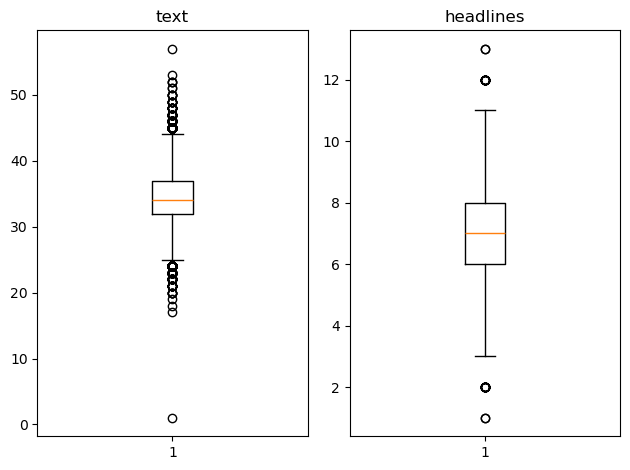

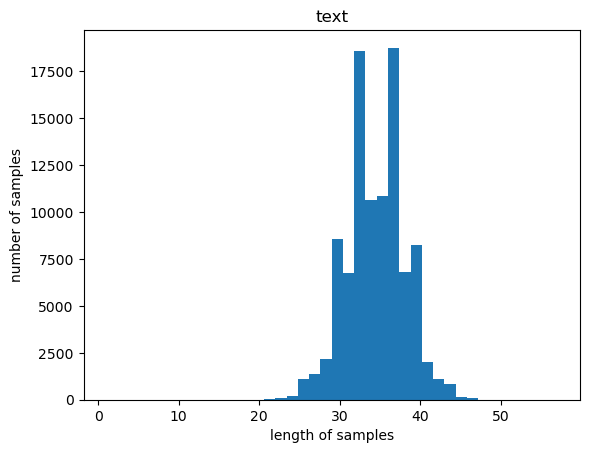

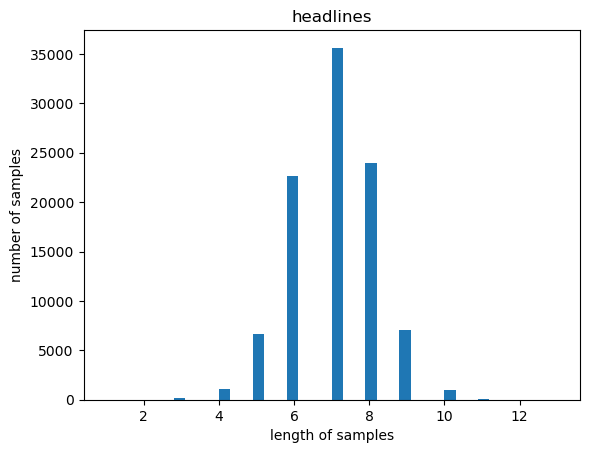

In [16]:
# 길이 분포 출력
import matplotlib.pyplot as plt
import numpy as np

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
text_max_len = 38
headlines_max_len = 11
print('=3')

=3


In [18]:
# max_len을 텍스트의 최대 토큰 수라 할 때, 전체 data에서 max_len보다 짧은 텍스트 샘플의 비율을 출력하는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [19]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.873332655551037
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9997763318422123


In [20]:
data.head()

,headlines,text
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iitb pg program mac...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharmaled india match wi...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...


In [21]:
data.iloc[12]

headlines                ram krishna smoke ramdev sadhus kumbh
text         urging saints seers kumbh mela quit smoking yo...
Name: 12, dtype: object

In [22]:
# text_max_len이나 headlines_max_len보다 짧은 데이터 필터링
data = data[
    data['text'].apply(lambda x: len(x.split()) <= text_max_len) &
    data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)
]

In [23]:
len(data)

85893

In [24]:
data.head()

,headlines,text
2,new zealand end rohit sharmaled india match wi...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...
5,rahat fateh ali khan denies getting notice smu...,pakistani singer rahat fateh ali khan denied r...
6,india get lowest odi total new zealand,india recorded lowest odi total new zealand ge...


#### encoder, decoder에 들어갈 데이터 준비

In [25]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharmaled india match wi...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharmaled india...,new zealand end rohit sharmaled india match wi...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken
5,rahat fateh ali khan denies getting notice smu...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice smu...
6,india get lowest odi total new zealand,india recorded lowest odi total new zealand ge...,sostoken india get lowest odi total new zealand,india get lowest odi total new zealand eostoken


In [26]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
# list of string으로 저장된다.
print('=3')

=3


In [27]:
# data 섞기 전 encoder_input
encoder_input

array(['new zealand defeated india wickets fourth odi hamilton thursday win first match fivematch odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
       'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental death benefit rider life cover age years',
       'speaking sexual harassment allegations rajkumar hirani sonam kapoor said known hirani many yearswhat true metoo movement get derailed metoo movement always believe woman case need reserve judgment added hirani accused assistant worked sanju',
       ...,
       'uff yeh first song sonakshi sinha starrer upcoming drama film noor released song composed amaal mallik vocals armaan malik lyrics manoj muntashir sonakshi seen portraying pakistani journalistwriter film directe

In [28]:
# data 랜덤하게 섞어주기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[13223 27404 61885 ... 72080  8319 31514]


In [29]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [30]:
# data 섞은 후 encoder_input
encoder_input

array(['police friday filed fir unknown persons allegedly displaying national flag upside rally led bjp leader rajiv jasrotia jammu kashmir kathua september vinod nijhawan local resident filed complaint stating act heinous hurt sentiments patriotic citizens india',
       'student appeared national eligibility cum entrance test kerala claimed asked remove bra entering exam metal hooks metal one prohibited items per cbse guidelines also filed complaint male invigilator alleging kept staring chest',
       'unitedleft alliance defeated akhil bharatiya vidyarthi parishad retain four central panel posts jawaharlal nehru university students union election results declared saturday unitedleft alliance student wings leftwing political parties total votes polled four posts including nota votes',
       ...,
       'toyota created human support robot help romulo camargo paralysed war veteran us army foottall kg robot open doors grab food water pantry deliver camargo extend body foot arm pick ob

In [31]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17178


In [32]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 68715
훈련 레이블의 개수 : 68715
테스트 데이터의 개수 : 17178
테스트 레이블의 개수 : 17178


### 정수 인코딩

기계가 텍스트를 숫자로 이해할 수 있도록 각 단어마다 고유의 정수를 부여해준다.

#### encoder를 위한 정수 인코딩
##### 최적화된 토크나이저 생성

우리의 data에서 가장 많이 등장하는 단어들 위주로 단어집합을 만든다.

In [33]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [34]:
threshold = 6
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 80741
등장 빈도가 5번 이하인 희귀 단어의 수: 57884
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22857
단어 집합에서 희귀 단어의 비율: 71.69096246021228
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.320356789930827


In [35]:
# 희귀 단어를 제외한 최빈 단어들에 한정해서 단어집합 생성.
src_vocab = 23000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 23,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


##### 생성된 단어집합(`{str: int}`)를 통해 텍스트 -> 정수 변환

In [36]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[6, 51, 166, 999, 2485, 1524, 39, 7292, 81, 1593, 8587, 1027, 357, 43, 97, 2407, 476, 258, 3979, 395, 3010, 465, 2828, 166, 401, 668, 425, 12619, 2042, 3180, 10490, 788, 3], [392, 1425, 81, 6186, 11132, 3407, 79, 288, 36, 60, 1412, 11466, 1986, 1546, 3738, 19463, 3738, 21, 4403, 1503, 120, 2318, 2691, 4, 166, 401, 1183, 1367, 1036, 11816, 2910], [1208, 774, 11133, 3374, 16300, 5454, 5216, 101, 329, 1469, 1574, 3543, 2757, 277, 147, 185, 378, 1150, 521, 77, 1208, 392, 7523, 13625, 457, 855, 289, 1388, 101, 1574, 91, 21043, 1388]]


#### decoder를 위한 정수 인코딩

위에서 encoder를 위해 했던 것과 같이 한다.

In [37]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [38]:
threshold = 4
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31527
등장 빈도가 3번 이하인 희귀 단어의 수: 19174
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 12353
단어 집합에서 희귀 단어의 비율: 60.81771180258191
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.170916338303727


In [39]:
tar_vocab = 12000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('decoder input',decoder_input_train[:5])
print('target')
print('decoder target',decoder_target_train[:5])

input
decoder input [[1, 2483, 5208, 5209, 89, 13, 979, 519, 855], [1, 74, 213, 104, 279, 757, 6453, 2083], [1, 111, 728, 1727, 117, 440, 171], [1, 2370, 1497, 74, 2764, 1094, 2428, 283], [1, 7, 19, 2615, 18, 13, 6874, 729, 10779, 2980, 2765]]
target
decoder target [[2483, 5208, 5209, 89, 13, 979, 519, 855, 2], [74, 213, 104, 279, 757, 6453, 2083, 2], [111, 728, 1727, 117, 440, 171, 2], [2370, 1497, 74, 2764, 1094, 2428, 283, 2], [7, 19, 2615, 18, 13, 6874, 729, 10779, 2980, 2765, 2]]


#### Drop!

빈도수가 낮은 단어들은 이제 단어집합에 없다. 유의미한 단어가 아예 없어진 샘플들을 data에서 삭제해준다.

In [40]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 2
훈련 데이터의 개수 : 68715
훈련 레이블의 개수 : 68715
테스트 데이터의 개수 : 17176
테스트 레이블의 개수 : 17176


#### 패딩

In [41]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='pre')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='pre')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='pre')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='pre')
print('=3')

=3


## 모델 설계

In [42]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### callback function 설계

In [43]:
early_stopping = EarlyStopping(monitor="val_loss",
                               patience=3,
                               mode="min",
                               verbose=1,
                               restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath="best_model.h5", 
                             monitor="val_loss",
                             mode="min",
                             verbose=1,
                             save_best_only=True)

### encoder 설계

In [44]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_outputs, state_h3, state_c3 = encoder_lstm3(encoder_output2)

### decoder 설계

In [45]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

### attention layer 추가

In [46]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 38)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 38, 128)   │  2,944,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 38, 256), │    394,240 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 38, 256), │    525,312 │ lstm[0][0]        │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 128) │  1,536,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 38, 256), │    525,312 │ lstm_1[0][0]      │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    394,240 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm_2[0][1],     │
│                     │ 256), (None,      │            │ lstm_2[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, None, 256) │        256 │ lstm_3[0][0],     │
│ (AdditiveAttention) │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None, 512) │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  6,156,000 │ concat_layer[0][… │
│                     │ 12000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,475,360 (47.59 MB)

 Trainable params: 12,475,360 (47.59 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=64, callbacks=[early_stopping, checkpoint], epochs=50)

Epoch 1/50


2025-04-20 16:25:46.941772: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.


   1/1074 ━━━━━━━━━━━━━━━━━━━━ 2:22:14 8s/step - loss: 9.3930

2025-04-20 16:25:48.899647: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.


   2/1074 ━━━━━━━━━━━━━━━━━━━━ 21:13 1s/step - loss: 9.3902  

2025-04-20 16:25:50.255930: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.


   3/1074 ━━━━━━━━━━━━━━━━━━━━ 20:31 1s/step - loss: 9.3871

2025-04-20 16:25:51.193927: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.


   4/1074 ━━━━━━━━━━━━━━━━━━━━ 19:37 1s/step - loss: 9.3833

2025-04-20 16:25:52.366042: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 5.2994
Epoch 1: val_loss improved from inf to 4.79362, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1484s 1s/step - loss: 5.2992 - val_loss: 4.7936
Epoch 2/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.8735
Epoch 2: val_loss improved from 4.79362 to 4.77677, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1693s 2s/step - loss: 4.8735 - val_loss: 4.7768
Epoch 3/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.8388
Epoch 3: val_loss improved from 4.77677 to 4.77094, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1605s 1s/step - loss: 4.8388 - val_loss: 4.7709
Epoch 4/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.8258
Epoch 4: val_loss improved from 4.77094 to 4.76488, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1555s 1s/step - loss: 4.8258 - val_loss: 4.7649
Epoch 5/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.8046
Epoch 5: val_loss improved from 4.76488 to 4.74198, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1574s 1s/step - loss: 4.8046 - val_loss: 4.7420
Epoch 6/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.7695
Epoch 6: val_loss improved from 4.74198 to 4.71681, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1630s 2s/step - loss: 4.7695 - val_loss: 4.7168
Epoch 7/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.7342
Epoch 7: val_loss improved from 4.71681 to 4.69787, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1572s 1s/step - loss: 4.7342 - val_loss: 4.6979
Epoch 8/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.7079
Epoch 8: val_loss improved from 4.69787 to 4.68515, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1547s 1s/step - loss: 4.7079 - val_loss: 4.6851
Epoch 9/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.6723
Epoch 9: val_loss improved from 4.68515 to 4.66702, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1572s 1s/step - loss: 4.6723 - val_loss: 4.6670
Epoch 10/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.6519
Epoch 10: val_loss improved from 4.66702 to 4.65107, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1571s 1s/step - loss: 4.6519 - val_loss: 4.6511
Epoch 11/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.6172
Epoch 11: val_loss improved from 4.65107 to 4.62653, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1581s 1s/step - loss: 4.6172 - val_loss: 4.6265
Epoch 12/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.5760
Epoch 12: val_loss improved from 4.62653 to 4.59158, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1566s 1s/step - loss: 4.5760 - val_loss: 4.5916
Epoch 13/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.5354
Epoch 13: val_loss improved from 4.59158 to 4.55930, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1546s 1s/step - loss: 4.5354 - val_loss: 4.5593
Epoch 14/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.4796
Epoch 14: val_loss improved from 4.55930 to 4.52448, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1563s 1s/step - loss: 4.4796 - val_loss: 4.5245
Epoch 15/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.4334
Epoch 15: val_loss improved from 4.52448 to 4.49071, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1599s 1s/step - loss: 4.4335 - val_loss: 4.4907
Epoch 16/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.3949
Epoch 16: val_loss improved from 4.49071 to 4.46485, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1508s 1s/step - loss: 4.3949 - val_loss: 4.4649
Epoch 17/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.3504
Epoch 17: val_loss improved from 4.46485 to 4.43682, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1542s 1s/step - loss: 4.3504 - val_loss: 4.4368
Epoch 18/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.3091
Epoch 18: val_loss improved from 4.43682 to 4.41537, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1541s 1s/step - loss: 4.3091 - val_loss: 4.4154
Epoch 19/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.2637
Epoch 19: val_loss improved from 4.41537 to 4.39986, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1562s 1s/step - loss: 4.2637 - val_loss: 4.3999
Epoch 20/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.2340
Epoch 20: val_loss improved from 4.39986 to 4.37529, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1586s 1s/step - loss: 4.2340 - val_loss: 4.3753
Epoch 21/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.1964
Epoch 21: val_loss improved from 4.37529 to 4.36142, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1537s 1s/step - loss: 4.1964 - val_loss: 4.3614
Epoch 22/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.1675
Epoch 22: val_loss improved from 4.36142 to 4.34969, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1540s 1s/step - loss: 4.1675 - val_loss: 4.3497
Epoch 23/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.1393
Epoch 23: val_loss improved from 4.34969 to 4.32905, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1572s 1s/step - loss: 4.1393 - val_loss: 4.3291
Epoch 24/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.1038
Epoch 24: val_loss improved from 4.32905 to 4.31559, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1851s 2s/step - loss: 4.1038 - val_loss: 4.3156
Epoch 25/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.0762
Epoch 25: val_loss improved from 4.31559 to 4.30317, saving model to best_model.h5


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 1832s 2s/step - loss: 4.0762 - val_loss: 4.3032
Epoch 26/50
 190/1074 ━━━━━━━━━━━━━━━━━━━━ 24:38 2s/step - loss: 4.0330

KeyboardInterrupt: 

In [48]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

NameError: name 'history' is not defined